The goal of this lab is to explore hyperparameter search/tuning with the package [Optuna](https://https://optuna.org/)

As before, firstly, we will start with the familiar [MNIST](https://https://en.wikipedia.org/wiki/MNIST_database) dataset.

However, first of all, let's just install the Optuna library:

In [1]:
pip install optuna

# Importing needed libraries

In [2]:
!pip install scikeras[tensorflow]      # gpu compute platform

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import seaborn as sns
import warnings
import optuna
import scikeras

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import *
from tensorflow.keras import utils
#from tf.keras.optimizers import *
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
#from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier

# Utility functions

In [4]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

# Main section

Let's import and prepare the MNIST dataset first as we did in the previous lab.

In [5]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
print("Training data shape: ", x_train.shape) # (60000, 28, 28) -- 60000 images, each 28x28 pixels
print("Test data shape", x_test.shape) # (10000, 28, 28) -- 10000 images, each 28x28
print("Training response shape:, ", y_train.shape)
print("Testing response shape: ", y_test.shape)

image_size = (x_train.shape[1], x_train.shape[2])

Training data shape:  (60000, 28, 28)
Test data shape (10000, 28, 28)
Training response shape:,  (60000,)
Testing response shape:  (10000,)


In [7]:
# Flatten the images
image_vector_size = image_size[0] * image_size[1] # 28 * 28
x_train = x_train.reshape(x_train.shape[0], image_vector_size) /255.
x_test = x_test.reshape(x_test.shape[0], image_vector_size) /255.
print(x_train.shape)

(60000, 784)


In [8]:
print("First 5 training labels: ", y_train[:5]) # [5, 0, 4, 1, 9]

# Convert to "one-hot" vectors using the to_categorical function
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print("First 5 training lables as one-hot encoded vectors:\n", y_train[:5])
print(y_train.shape)

First 5 training labels:  [5 0 4 1 9]
First 5 training lables as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(60000, 10)



Again, we will start by defining the model from the Sequential() function and adding some Dense (fully-connected) layers.
Here we will be starting with a simple network with just a single hidden layer with 32 neurons.
Make sure you set the size of the output layer to be the number of classes that we are trying to predict!
We can have a look at our model using the model.summary() function

In [9]:
#image_size = 784 # 28*28
#num_classes = 10 # ten unique digits
def build_basic_model():
  model = Sequential()

  # The input layer requires the special input_shape parameter which should match
  # the shape of our training data.
  model.add(Dense(units=32, activation='sigmoid', input_shape=(image_vector_size,)))
  model.add(Dense(units=num_classes, activation='softmax'))
  return model
model = build_basic_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │          25,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,450 (99.41 KB)

 Trainable params: 25,450 (99.41 KB)

 Non-trainable params: 0 (0.00 B)

Let's compile our model, train for for 5 epochs and examine the perfomance

In [10]:
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
history = model.fit(x_train, y_train, batch_size=128, epochs=5, verbose=True, validation_split=.1)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2035 - loss: 2.3225 - val_accuracy: 0.6538 - val_loss: 1.9966
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6464 - loss: 1.9384 - val_accuracy: 0.7552 - val_loss: 1.6916
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7231 - loss: 1.6496 - val_accuracy: 0.7923 - val_loss: 1.4135
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7599 - loss: 1.3993 - val_accuracy: 0.8228 - val_loss: 1.1902
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7899 - loss: 1.1982 - val_accuracy: 0.8468 - val_loss: 1.0205


Test loss: 1.05
Test accuracy: 0.819


<Figure size 800x600 with 0 Axes>

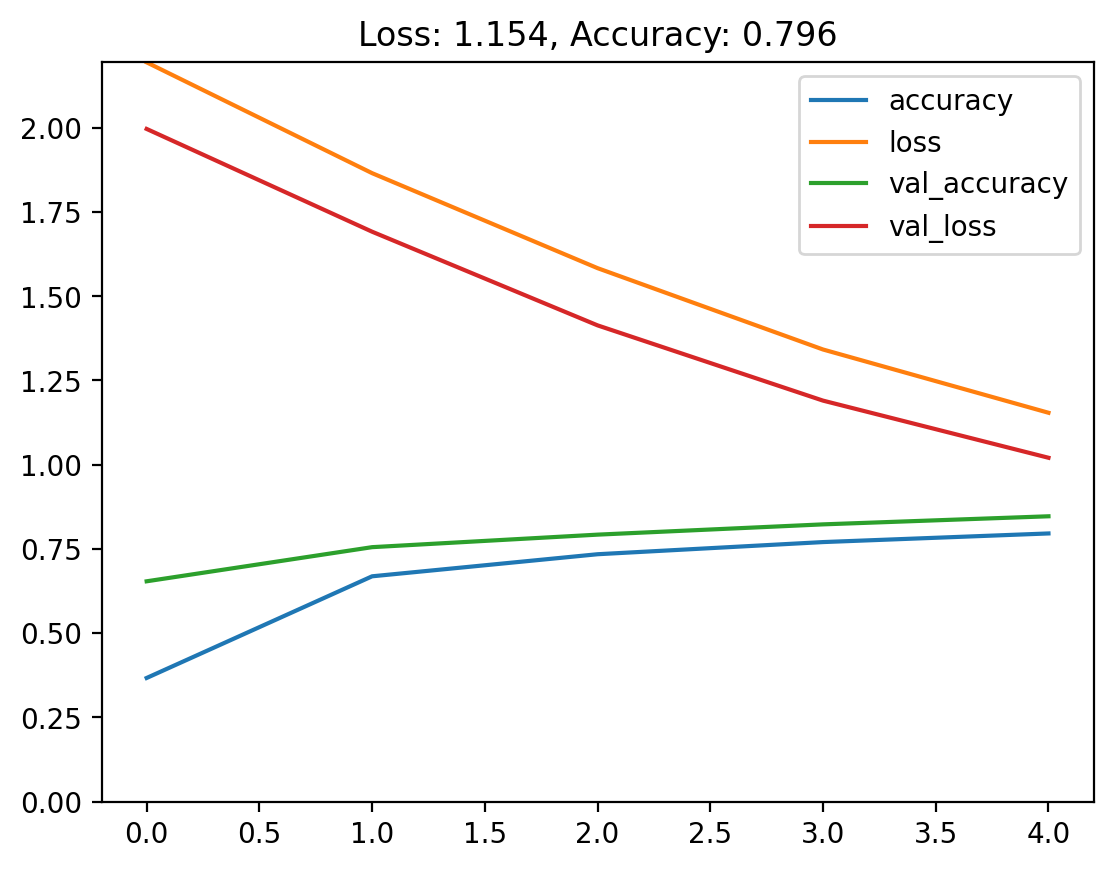

In [12]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

As we can see above, the perfomance of our model is not too bad.

We did try default learning rate, so, for our SGD optimizer. Can you tell what the value of the defaul learning rate we used? Hint: See documentaion for Keras SGD optimizer.

Learning rate is a **hyperparameter**, because we set it before we started the training process. What if we can tune the learning rate and choose the one which gives us better result on the validation set instead?

We could try different values by hand (for example, 0.1, 0.2, 0.3) but it might take some time. Why not to use better search strategies? Let's use a package called **Optuna**.

Below, we will set up so called **Trial**, where we define our model, hyperparameters that we would like to examine - learning rate and the objective function - accuracy on the validation set after 5 epochs.  
We will sample various learning rates between 1e-5 and 1e-1 (uniformly distributed on the logarithmic scale).  



In [19]:
def objective(trial):
    model = build_basic_model()
    # We compile our model with a sampled learning rate.
    lr = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True) #sample value of learning rate between 1e-5 and 1e-1
    model.compile(tf.keras.optimizers.SGD(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size=128, epochs=5, verbose=True, validation_split=.1)
    acc = history.history['val_accuracy'][-1]
    return acc #we will use validation accuracy to compare perfomance of models trained with sample learning rates

In [15]:
import tensorflow as tf

Next we will sample 10 different learning rates and evaluate perfomance. It might take a bit of time, that's why we only use 5 epochs.

In [20]:
study = optuna.create_study(direction='maximize') # we would like to maximise the validation accuracy
study.optimize(objective, n_trials=10) #use objective function defined above and sample 10 different learning rates

[I 2024-04-22 12:08:53,556] A new study created in memory with name: no-name-77c23043-be80-4441-bf3a-cd47714e3d59


Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1021 - loss: 2.4712 - val_accuracy: 0.1045 - val_loss: 2.4603
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1004 - loss: 2.4642 - val_accuracy: 0.1045 - val_loss: 2.4514
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1003 - loss: 2.4552 - val_accuracy: 0.1042 - val_loss: 2.4430
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1002 - loss: 2.4467 - val_accuracy: 0.1040 - val_loss: 2.4350
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1015 - loss: 2.4372 - val_accuracy: 0.1040 - val_loss: 2.4274


[I 2024-04-22 12:09:03,295] Trial 0 finished with value: 0.10400000214576721 and parameters: {'learning_rate': 4.062523721476323e-05}. Best is trial 0 with value: 0.10400000214576721.


Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0838 - loss: 2.4475 - val_accuracy: 0.0835 - val_loss: 2.4484
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0827 - loss: 2.4452 - val_accuracy: 0.0828 - val_loss: 2.4435
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0826 - loss: 2.4389 - val_accuracy: 0.0825 - val_loss: 2.4387
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0837 - loss: 2.4282 - val_accuracy: 0.0810 - val_loss: 2.4341
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0799 - loss: 2.4269 - val_accuracy: 0.0800 - val_loss: 2.4295


[I 2024-04-22 12:09:13,043] Trial 1 finished with value: 0.07999999821186066 and parameters: {'learning_rate': 3.230983393574626e-05}. Best is trial 0 with value: 0.10400000214576721.


Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3040 - loss: 2.1778 - val_accuracy: 0.7138 - val_loss: 1.6270
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6931 - loss: 1.5266 - val_accuracy: 0.7980 - val_loss: 1.1627
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7760 - loss: 1.1338 - val_accuracy: 0.8483 - val_loss: 0.8859
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8180 - loss: 0.9013 - val_accuracy: 0.8698 - val_loss: 0.7186
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8397 - loss: 0.7546 - val_accuracy: 0.8833 - val_loss: 0.6116


[I 2024-04-22 12:09:21,672] Trial 2 finished with value: 0.8833333253860474 and parameters: {'learning_rate': 0.02006661845012133}. Best is trial 2 with value: 0.8833333253860474.


Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2532 - loss: 2.2837 - val_accuracy: 0.6662 - val_loss: 1.8533
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6588 - loss: 1.7760 - val_accuracy: 0.7550 - val_loss: 1.4845
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7356 - loss: 1.4450 - val_accuracy: 0.7993 - val_loss: 1.2115
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7739 - loss: 1.2054 - val_accuracy: 0.8343 - val_loss: 1.0139
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8035 - loss: 1.0266 - val_accuracy: 0.8535 - val_loss: 0.8707


[I 2024-04-22 12:09:33,917] Trial 3 finished with value: 0.8535000085830688 and parameters: {'learning_rate': 0.012403593278711126}. Best is trial 2 with value: 0.8833333253860474.


Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0947 - loss: 2.4839 - val_accuracy: 0.0980 - val_loss: 2.4774
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0923 - loss: 2.4785 - val_accuracy: 0.0985 - val_loss: 2.4722
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0935 - loss: 2.4688 - val_accuracy: 0.0987 - val_loss: 2.4672
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0945 - loss: 2.4659 - val_accuracy: 0.0988 - val_loss: 2.4622
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0954 - loss: 2.4609 - val_accuracy: 0.0992 - val_loss: 2.4574


[I 2024-04-22 12:09:43,215] Trial 4 finished with value: 0.09916666895151138 and parameters: {'learning_rate': 2.3690962305055365e-05}. Best is trial 2 with value: 0.8833333253860474.


Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0975 - loss: 2.4717 - val_accuracy: 0.1137 - val_loss: 2.3506
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1293 - loss: 2.3354 - val_accuracy: 0.1823 - val_loss: 2.2762
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1916 - loss: 2.2692 - val_accuracy: 0.2233 - val_loss: 2.2293
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2283 - loss: 2.2254 - val_accuracy: 0.2672 - val_loss: 2.1938
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2735 - loss: 2.1925 - val_accuracy: 0.3458 - val_loss: 2.1635


[I 2024-04-22 12:09:53,122] Trial 5 finished with value: 0.34583333134651184 and parameters: {'learning_rate': 0.0007988933774182301}. Best is trial 2 with value: 0.8833333253860474.


Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1334 - loss: 2.3666 - val_accuracy: 0.1553 - val_loss: 2.3349
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1479 - loss: 2.3365 - val_accuracy: 0.1700 - val_loss: 2.3074
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1633 - loss: 2.3116 - val_accuracy: 0.1797 - val_loss: 2.2833
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1773 - loss: 2.2866 - val_accuracy: 0.1933 - val_loss: 2.2617
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1966 - loss: 2.2636 - val_accuracy: 0.2085 - val_loss: 2.2421


[I 2024-04-22 12:10:00,206] Trial 6 finished with value: 0.2084999978542328 and parameters: {'learning_rate': 0.0003634357960240219}. Best is trial 2 with value: 0.8833333253860474.


Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1005 - loss: 2.3394 - val_accuracy: 0.0968 - val_loss: 2.3141
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1026 - loss: 2.3020 - val_accuracy: 0.1038 - val_loss: 2.2836
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1125 - loss: 2.2750 - val_accuracy: 0.1297 - val_loss: 2.2585
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1382 - loss: 2.2505 - val_accuracy: 0.1722 - val_loss: 2.2367
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1796 - loss: 2.2322 - val_accuracy: 0.2188 - val_loss: 2.2171


[I 2024-04-22 12:10:09,820] Trial 7 finished with value: 0.218833327293396 and parameters: {'learning_rate': 0.0003753930937212501}. Best is trial 2 with value: 0.8833333253860474.


Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0809 - loss: 2.3697 - val_accuracy: 0.0872 - val_loss: 2.3647
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0850 - loss: 2.3602 - val_accuracy: 0.0920 - val_loss: 2.3539
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0937 - loss: 2.3478 - val_accuracy: 0.0983 - val_loss: 2.3438
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0978 - loss: 2.3418 - val_accuracy: 0.1058 - val_loss: 2.3341
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1067 - loss: 2.3325 - val_accuracy: 0.1140 - val_loss: 2.3250


[I 2024-04-22 12:10:19,366] Trial 8 finished with value: 0.11400000005960464 and parameters: {'learning_rate': 0.00013830859239294803}. Best is trial 2 with value: 0.8833333253860474.


Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1141 - loss: 2.5381 - val_accuracy: 0.1050 - val_loss: 2.5142
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1127 - loss: 2.4957 - val_accuracy: 0.1053 - val_loss: 2.4728
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1129 - loss: 2.4554 - val_accuracy: 0.1068 - val_loss: 2.4387
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1159 - loss: 2.4216 - val_accuracy: 0.1097 - val_loss: 2.4101
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1161 - loss: 2.4009 - val_accuracy: 0.1137 - val_loss: 2.3858


[I 2024-04-22 12:10:28,901] Trial 9 finished with value: 0.11366666853427887 and parameters: {'learning_rate': 0.00013637009708234417}. Best is trial 2 with value: 0.8833333253860474.


In [21]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

Let's see how our validation accuracy (Y axis) changed during 10 trials

In [22]:
plot_optimization_history(study)

Let's see what was the best value (gives best validation accuracy) of learning rate which Optuna found. Is it different from the default value of the Keras SGD optimiser?

In [23]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

Number of finished trials: 10
Best trial:
  Value: 0.8833333253860474
  Params: 
    learning_rate: 0.02006661845012133


In [24]:
print(study.best_params['learning_rate'])

0.02006661845012133


Finally, let's use use this new learning rate, train our model and evaluate perfomance on the test set. Did we get improved result?

In [25]:
model = build_basic_model()
# We compile our model with a sampled learning rate.
lr=study.best_params['learning_rate']
#lr=0.01
model.compile(tf.keras.optimizers.SGD(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=5, verbose=True, validation_split=.1)


loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3303 - loss: 2.1645 - val_accuracy: 0.7222 - val_loss: 1.5805
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7046 - loss: 1.4871 - val_accuracy: 0.8010 - val_loss: 1.1275
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7731 - loss: 1.1070 - val_accuracy: 0.8448 - val_loss: 0.8750
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8094 - loss: 0.8928 - val_accuracy: 0.8642 - val_loss: 0.7216
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8278 - loss: 0.7623 - val_accuracy: 0.8788 - val_loss: 0.6207
Test loss: 0.665
Test accuracy: 0.857


Try to explore with tuning other hyperparameters in the model and see what happens. To tune categorial parameters, such as optmiser name, please see here: [categorical](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_categorical)